<a href="https://colab.research.google.com/github/norhanhassan144/CNN-LSTM/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import zipfile
import os

files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d datamunge/sign-language-mnist

with zipfile.ZipFile("sign-language-mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("sign_language_data")

!ls sign_language_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
american_sign_language.PNG  amer_sign3.png   sign_mnist_test.csv  sign_mnist_train.csv
amer_sign2.png		    sign_mnist_test  sign_mnist_train


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import random


In [4]:
train = pd.read_csv("sign_language_data/sign_mnist_train.csv")
test = pd.read_csv("sign_language_data/sign_mnist_test.csv")

print(train.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       20

In [5]:
# استخراج التصنيفات (الأحرف)
y_train = train['label'].values
y_test = test['label'].values

# إزالة العمود الأول لأنه يحتوي على التصنيفات فقط
x_train = train.drop(columns=['label']).values
x_test = test.drop(columns=['label']).values

# تحويل البيانات إلى شكل صور (28x28)
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

x_train = x_train / 255.0
x_test = x_test / 255.0

# تحويل التصنيفات إلى One-Hot Encoding
y_train = to_categorical(y_train, num_classes=25)
y_test = to_categorical(y_test, num_classes=25)

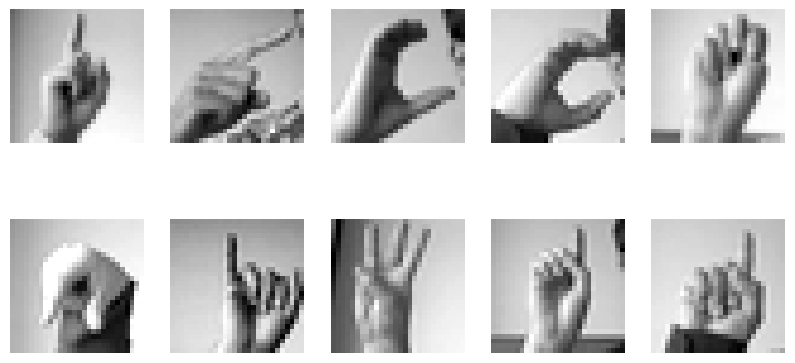

In [6]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [7]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),  # لتقليل Overfitting

    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    LSTM(64, return_sequences=False, dropout=0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(25, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │           5,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 14, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,273 (301.85 KB)

 Trainable params: 77,273 (301.85 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 67s 66ms/step - accuracy: 0.0993 - loss: 2.9647 - val_accuracy: 0.3370 - val_loss: 2.0118
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.3795 - loss: 1.8443 - val_accuracy: 0.5219 - val_loss: 1.4218
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.5430 - loss: 1.3285 - val_accuracy: 0.6343 - val_loss: 1.1292
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - accuracy: 0.6533 - loss: 1.0040 - val_accuracy: 0.6870 - val_loss: 0.9693
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 83s 57ms/step - accuracy: 0.7242 - loss: 0.8029 - val_accuracy: 0.7243 - val_loss: 0.8464
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 80s 54ms/step - accuracy: 0.7729 - loss: 0.6579 - val_accuracy: 0.7688 - val_loss: 0.7783
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - accuracy: 0.8092 - loss: 0.5503 - val_accuracy: 0.7733 - val_loss: 0.7900
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 84s 57ms/step - accuracy: 0.8432 - loss: 0.4463 - 

In [9]:
# تقييم النموذج
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8108 - loss: 0.6188
Test Accuracy: 81.82%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


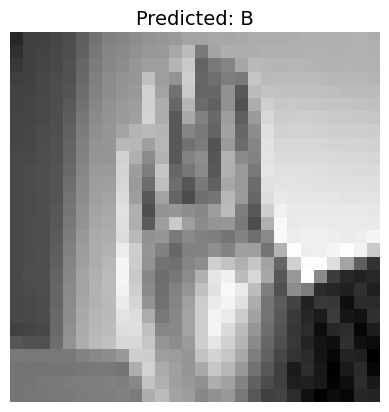

In [14]:
import random

# الأحرف التي يتم تصنيفها
labels = "ABCDEFGHIKLMNOPQRSTUVWXY"  # بدون J و Z

idx = random.randint(0, len(x_test) - 1)
sample = x_test[idx].reshape(1, 28, 28)

prediction = model.predict(sample)
predicted_label = np.argmax(prediction)

plt.imshow(x_test[idx], cmap="gray")
plt.title(f"Predicted: {labels[predicted_label]}", fontsize=14)
plt.axis("off")
plt.show()
